# Recuperação dos dados

Os dados foram obtidos de https://github.com/amitt001/Android-App-Reviews-Dataset

In [97]:
import os

URL_ROOT = 'https://raw.githubusercontent.com/amitt001/Android-App-Reviews-Dataset/master/'

POSITIVE_REVIEWS_DATA_URL = URL_ROOT+'positive10k.txt'
NEGATIVE_REVIEWS_DATA_URL = URL_ROOT+'negative10k.txt'

DATA_PATH = os.path.join('..', 'data', 'raw')
POSITIVE_DATA_FILE = os.path.join(DATA_PATH, 'positive10k.txt')
NEGATIVE_DATA_FILE = os.path.join(DATA_PATH, 'negative10k.txt')


In [99]:
import urllib

def download_data(data_url, data_path, data_file):
    os.makedirs(data_path, exist_ok=True)
    urllib.request.urlretrieve(data_url, data_file)

download_data(POSITIVE_REVIEWS_DATA_URL, DATA_PATH, POSITIVE_DATA_FILE)
download_data(NEGATIVE_REVIEWS_DATA_URL, DATA_PATH, NEGATIVE_DATA_FILE)

In [101]:
import pandas as pd

positive_df = pd.read_csv(POSITIVE_DATA_FILE,  delimiter = "\t", header=None, names=['reviews'])
negative_df = pd.read_csv(NEGATIVE_DATA_FILE,  delimiter = "\t", header=None, names=['reviews'])

In [103]:
#Adiciona coluna com 0 pra negativo e 1 pra positivo e concatena os dataframes
positive_df['label'] = 1
negative_df['label'] = 0
data = pd.concat([positive_df, negative_df])

In [105]:
data.head()

,reviews,label
0,Very simple and effective way for new words fo...,1
1,Fh d Fcfatgv,1
2,My son loved it. It is easy even though my son...,1
3,Brilliant A brilliant app that is challenging ...,1
4,Good I have gotten several updates and new gam...,1


In [107]:
data.shape

(19655, 2)

In [109]:
#Pegando só uma amostra pra melhorar o desempenho
data = data.sample(frac=0.4, replace=False, random_state=42)

In [110]:
data.shape

(7862, 2)

# Preparação dos dados

Download do modelo do spacy e das stopwords do nltk. Descomentar as linhas ao rodas pela primeira vez.

In [111]:
# import spacy.cli
# spacy.cli.download("en_core_web_sm")

In [112]:
# import nltk
# nltk.download('stopwords')

## Preparando os dados

In [113]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [114]:
from nltk.corpus import stopwords
stopwords_en = stopwords.words("english")

Removendo as stopwords que são úteis para a análise do conjunto de stop words

In [115]:
to_remove = [ 'not',  "aren't", "couldn't", "don't"]

for word in to_remove:
    stopwords_en.remove(word)


Função que limpa o texto filtrando somente as letras, retirando as stopword e lematizando. 

In [116]:
import re
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[\W\d_]+", " ", text)
    text = [word for word in text.split() if word not in stopwords_en]
    nlp_text = nlp(" ".join(text))
    tokens = [word.lemma_ if word.lemma_ != "-PRON-" else word.lower_ for word in nlp_text]
    return " ".join(tokens)

In [117]:
data['reviews'] = data['reviews'].apply(clean_text)

In [118]:
data.head()

,reviews,label
2909,bore without well control display,0
4546,food great game amongst other definately enter...,1
5927,excellent use free version till entry upgrade ...,1
5466,thank love wonderful thing well nail salon ama...,1
4797,home screen app ok aster recent update homepag...,0


# Testando os modelos

In [119]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

text = data['reviews']

vectorizer = CountVectorizer(binary=True, max_features=5000)
X_bow = vectorizer.fit_transform(text)

tfidf_vect = TfidfVectorizer(max_features=5000)
vectorizer = tfidf_vect.fit(text)
X_tfidf = vectorizer.transform(text)
y = data['label']

In [120]:
from sklearn.model_selection import train_test_split
X1_train, X1_test, y1_train, y1_test = train_test_split(X_bow, y, test_size=0.3, random_state = 42)
X2_train, X2_test, y2_train, y2_test = train_test_split(X_tfidf, y, test_size=0.3, random_state = 42)


## Testando os modelos com o GridSearchCV

In [121]:
import sklearn

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [122]:
def build_classifiers():
    classifiers = []
    classifiers.append(
                      ('knn',                              # nome do classificador
                        KNeighborsClassifier(),            # instancia do classificador
                        {'n_neighbors' : range(1, 33, 2)}  # hiperparametros
                      )
    )
    
    classifiers.append(
                      ('lr',                               
                        LogisticRegression(max_iter=1000), 
                        {'penalty' : ['l2'], 'C' : [100, 10, 1, 0.1, 0.01]}  
                      )
    )
    
    classifiers.append(
                      ('dt',
                        DecisionTreeClassifier(),
                        {'max_depth' : [2, 4, 6, 8, 10, 12]}
                      )  
    )
    
    classifiers.append(
                      ('rf',
                        RandomForestClassifier(),
                        {'n_estimators' : [10, 50, 100]}
                      ) 
    )

    return classifiers

In [96]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import KFold

classifiers = build_classifiers()

for name, model , parameters in classifiers:
    print('\n>> Classifier name: {}'.format(name))
    gs = GridSearchCV(estimator=model, param_grid=parameters, refit=True, cv = 5, n_jobs=3)
    gs.fit(X1_train, y1_train)
    print("BOW Best parameters: {}".format(gs.best_params_))
    print("BOW Best score: {}".format(gs.best_score_))
    gs.fit(X2_train, y2_train)
    print("TFIDF Best parameters: {}".format(gs.best_params_))
    print("TFIDFBest score: {}".format(gs.best_score_))


>> Classifier name: knn
BOW Best parameters: {'n_neighbors': 3}
BOW Best score: 0.751773263974899
TFIDF Best parameters: {'n_neighbors': 3}
TFIDFBest score: 0.6123955082156717

>> Classifier name: lr
BOW Best parameters: {'C': 1, 'penalty': 'l2'}
BOW Best score: 0.8713435719593757
TFIDF Best parameters: {'C': 1, 'penalty': 'l2'}
TFIDFBest score: 0.8727969614400133

>> Classifier name: dt
BOW Best parameters: {'max_depth': 10}
BOW Best score: 0.792479894310957
TFIDF Best parameters: {'max_depth': 10}
TFIDFBest score: 0.7826676575014451

>> Classifier name: rf
BOW Best parameters: {'n_estimators': 100}
BOW Best score: 0.8555338122368095
TFIDF Best parameters: {'n_estimators': 100}
TFIDFBest score: 0.8529903393609116


In [98]:
clf = LogisticRegression(max_iter=1000, C = 1, penalty = 'l2')
clf.fit(X2_train, y2_train)
y_pred = clf.predict(X2_test)

## Acurácia do modelo escolhido

In [100]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()

def show_accuracy(y_true, y_pred):
  print("Acurácia: ", accuracy_score(y_true, y_pred))
  print("\nAUROC:", roc_auc_score(y_true, y_pred))
  print("\nF1-Score:", f1_score(y_true, y_pred, average='weighted'))
  print("\nMatriz de confusão:")
  sns.heatmap(confusion_matrix(y_true, y_pred), annot=True)
  plt.show()

Acurácia:  0.8766426451886392

AUROC: 0.8766860314630007

F1-Score: 0.876649473621947

Matriz de confusão:


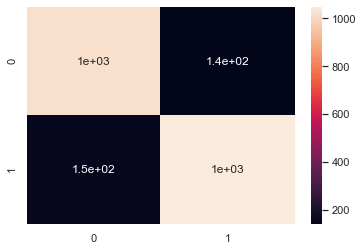

In [102]:
show_accuracy(y2_test, y_pred)

# Testes com o modelo treinado

In [104]:
def predict_label(text):
    text = clean_text(text)
    text = vectorizer.transform([text])
    label = clf.predict(text)[0]
    if label == 0:
        return "Negativo"
    elif label == 1:
        return "Positivo"
    else:
        return "Neutro"



In [106]:
reviews = ['Its a good app', "its a bad app", "Better app", "Worst app", "I like it", "I dont like it"]
for review in reviews:
    print(f"Review: {review} --> TAG: {predict_label(review)}")


Review: Its a good app --> TAG: Positivo
Review: its a bad app --> TAG: Negativo
Review: Better app --> TAG: Positivo
Review: Worst app --> TAG: Negativo
Review: I like it --> TAG: Positivo
Review: I dont like it --> TAG: Negativo


# Deploy do modelo


In [108]:
import joblib

DEPLOY_PATH = os.path.join('..', 'model')
DEPLOY_MODEL_FILE = 'model.joblib'
DEPLOY_VECTORIZER_FILE = 'vectorizer.joblib'

os.makedirs(DEPLOY_PATH, exist_ok=True)

deploy_model = os.path.join(DEPLOY_PATH, DEPLOY_MODEL_FILE)
deploy_vectorizer = os.path.join(DEPLOY_PATH, DEPLOY_VECTORIZER_FILE)

joblib.dump(clf, deploy_model)
joblib.dump(vectorizer, deploy_vectorizer)


['../model/vectorizer.joblib']